özel veri kümesi kullanarak askeri uçak görünyü sınıflandırması

Bu projede Görüntü Sınıflandırma için Transfer Öğrenmeyi kullanacağız.
1. Bu projede hem eğitim hem de test için kendi özel veri setimizi kullanacağız.
2. VGG16 önceden eğitilmiş karmaşık derin öğrenme modelini kullanacağız

Veri seti olarak MTARSI'den (Muti-type Aircraft of Remote Sensing Images, https://zenodo.org/record/3464319#.YUiSrrgzaUk) alınan uçak görüntüleri kullanılmış ancak veri seti boyutu küçültülmüş ve görüntüler eğitim amacıyla yeniden düzenlenmiş.

MTARSI görüntüleri genellikle internette bulunan uydu görüntülerinden elde edilen uzaktan algılama görüntüleridir.

In [ ]:
!pip3 install matplotlib


In [27]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [25]:
#Öncelikle tren ve test görüntü yollarımızı tanımlayacağız.
train_files_path = "/content/drive/MyDrive/airplanedataset/Train"
test_files_path = "/content/drive/MyDrive/airplanedataset/Test"


In [21]:
img = load_img("/content/drive/MyDrive/airplanedataset/Test/B-52/3-1.jpg")


In [22]:
print(img_to_array(img).shape)

(230, 266, 3)


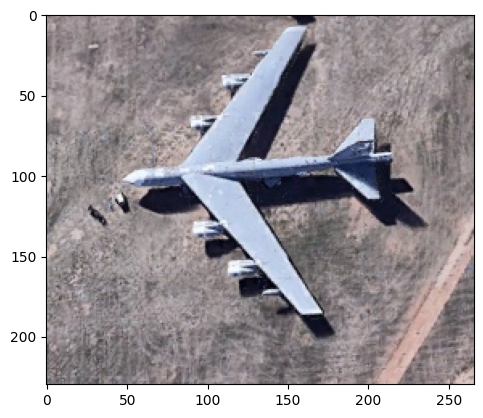

In [23]:
plt.imshow(img)
plt.show()

In [28]:
train_data = ImageDataGenerator().flow_from_directory(train_files_path,target_size = (224,224))
test_data = ImageDataGenerator().flow_from_directory(test_files_path,target_size = (224,224))


Found 1812 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [29]:
numberOfAirplaneTypes = 5

Projemizde Transfer Learning özel olarak VGG16 modelini kullanacağız!..
Bur VGG16 modelinin hem eğitim hem de test için kendine ait girişleri var bu nedenle girişleri değiştirmemiz gerekiyor..

Orijinal VGG16 modeli, özellikle uçak görüntüleri olmayan 1000 görüntü kategorisine sahip ImageNet veri kümesi (yaklaşık 22.000 kategoriye ait 15 milyondan fazla etiketli yüksek çözünürlüklü görüntüden oluşan bir veri kümesi) için tasarlanmıştır.
Bu, veri setimizdeki uçak görüntülerinin sınıflandırılması için yeni bir model oluşturacağımız ve bu yeni modelde VGG16 önceden eğitilmiş katmanları kullanacağımız anlamına geliyor.

In [30]:
vgg = VGG16()

553467096/553467096 [==============================] - 7s 0us/step


In [31]:
vgg_layers = vgg.layers
print(vgg_layers)

[<keras.src.engine.input_layer.InputLayer object at 0x7dbfb2373ee0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7dbfb2372e90>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7dbfb23b6860>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7dbfb23b5e70>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7dbfb23b74c0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7dbfb23b5240>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7dbfb240ad10>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7dbfb23b7af0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7dbfb2408520>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7dbfbea9b700>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7dbfb2409db0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7dbfbea9b730>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7dbfb24ef370>, <keras.src.layers.convolutional.co

In [32]:
vggmodel_layersize_tobe_used = len(vgg_layers) - 1

model = Sequential()
for i in range(vggmodel_layersize_tobe_used):
    model.add(vgg_layers[i])

In [33]:
for layers in model.layers:
    layers.trainable = False

# Since I have omitted the original output layer of VGG16, I have to add my new output layer to my new model!
model.add(Dense(numberOfAirplaneTypes, activation="softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [34]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [35]:

batch_size = 4

model.fit_generator(train_data,
                           steps_per_epoch=400//batch_size,
                           epochs= 3, # You can increase epoch size if you have a computer with good specs...
                           validation_data=test_data,
                           validation_steps= 200//batch_size)

<ipython-input-35-b38d1cbe9008>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data,


Epoch 1/3
 57/100 [================>.............] - ETA: 14:36 - loss: 0.6268 - accuracy: 0.8063

100/100 [==============================] - 1265s 12s/step - loss: 0.6268 - accuracy: 0.8063 - val_loss: 0.5100 - val_accuracy: 0.8300


modelin doğruluk oranı %83


In [36]:
img = Image.open("/content/drive/MyDrive/f22.jpg").resize((224,224))

In [37]:
img = np.array(img)

In [38]:
img.shape

(224, 224, 3)

In [39]:
print(img.ndim)

3


In [40]:
# Dizimize ekstra bir boyut eklememiz gerekiyor ki onu yeniden şekillendirelim.
img = img.reshape(-1,224,224,3)  # reshape(-1,..) ile ekstra 1 boyut ekliyoruz.

In [41]:
print(img.shape)
print(img.ndim)

(1, 224, 224, 3)
4


In [43]:
# Modelimin preprocess_input özelliğini kullanarak giriş piksellerini -1 ile 1 arasında ölçeklendireceğiz
#VGG16 modeli bunu gerektirir.
img = preprocess_input(img)

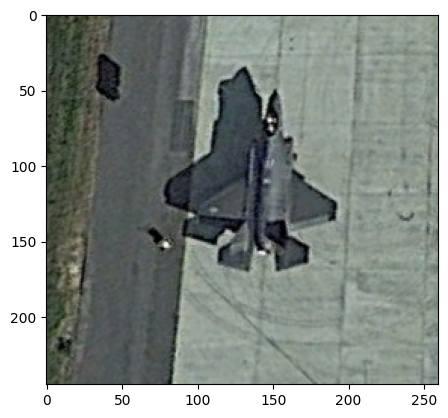

In [45]:
img_for_display = load_img("/content/drive/MyDrive/f22.jpg")
plt.imshow(img_for_display)
plt.show()

In [46]:
#tahmin..
preds = model.predict(img)


1/1 [==============================] - 2s 2s/step


In [47]:
preds

array([[2.7930234e-03, 3.0395063e-02, 2.1290381e-03, 9.6429127e-01,
        3.9166957e-04]], dtype=float32)

Bunlar her çıkışın *olasılıklarıdır*

Örneğin, üç sınıf etiketi 0, 1 ve 2 olarak tamsayı olarak kodlanacaktır. Daha sonra aşağıdaki gibi vektörlere kodlanacaktır:

Sınıf 0: [1, 0, 0]

Sınıf 1: [0, 1, 0]

Sınıf 2: [0, 0, 1]

Buna one-hot kodlama denir.

-----
Bizim durumumuzda:

A-10 Yıldırım: [1,0,0,0,0]

Boeing B-52: [0,1,0,0,0]

....
bunun gibi..

-----

Örneğin, tamsayı kodlu sınıf 1 bekleniyorsa, hedef vektör şöyle olacaktır:

[0, 1, 0]

----

Softmax çıktısı aşağıdaki gibi görünebilir; bu, en fazla ağırlığı sınıf 1'e ve daha az ağırlığı diğer sınıflara verir.


Örneğin yukarıdaki 3 çıkış örneğinde şöyle bir softmax çıkışımız olsaydı:

[0,09003057 0,67524096 0,23472847]

O halde en yüksek olasılıklı sonucun Sınıf 1 olan 0,67524096 olduğunu söyleyebiliriz.
Dizini yalnızca numpy'nin argmax işlevini kullanarak bulabilirim:


sınıf tamsayı = argmax([0,09003057 0,67524096 0,23472847])

In [48]:
image_classes = ["A-10 Thunderbolt","Boeing B-52","Boeing E-3 Sentry","F-22 Raptor","KC-10 Extender"]

result = np.argmax(preds[0])
print(image_classes[result])

F-22 Raptor
